# Finding the Band Gap 

## Equations
Densidad Óptica
\begin{equation}
O.D = \frac{\alpha l}{ln(10)}
\end{equation}
K (numero de onda) 
\begin{equation}
k = \frac{\alpha \lambda}{4\pi}
\end{equation}
Transmitancia y Reflectancia
\begin{align}
T = (1-R)^{2} e^{-\alpha l}\\
R =  1 -e^{\frac{1}{2}\alpha l}T^{\frac{1}{2}}    
\end{align}
Indice de refracción
\begin{equation}
R = \frac{(n-1)^2 + k^2}{(n+1)^2+k^2}
\end{equation}


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

## Variables

Importación de datos

In [105]:
class material:
            
    def __init__(self, name,l,refraction_coefficient):
        data = pd.read_excel('datos_tecnicas.xlsx')
        c1 = 100000000
        c2 = 100000000000
        self.name = name
        self.l = l
        self.refraction_coefficient = refraction_coefficient
        self.wavelength = pd.to_numeric(data["Wavelength"], errors='coerce')
        transmitancia = pd.to_numeric(data[f'{self.name}_T']/(c1), errors='coerce')
        reflectancia =  pd.to_numeric(data[f'{self.name}_R']/c1, errors='coerce')
        absorbancia =  pd.to_numeric(data[f'{self.name}_Abs']/c2, errors='coerce')
      
        while(transmitancia[transmitancia < 20].size > 0):
            transmitancia[transmitancia < 20] = transmitancia[transmitancia <20]*10
        while(absorbancia[absorbancia < 0.02].size > 0):
             absorbancia[absorbancia < 0.02] = absorbancia[absorbancia <0.02]*10
        while(reflectancia[reflectancia < 0.002].size > 0):
             reflectancia[reflectancia < 0.002] = reflectancia[reflectancia <0.002]*10
        self.transmitancia = transmitancia/100
        self.reflectancia = reflectancia/1000
        self.absorbancia =absorbancia   
       
        
    def R_theoric_calc(self):
        '''
        Calcula la transmitancia con  R = 1 - e**(0.5*self.absorbancia*l)*transmitancia
        '''
        size = self.absorbancia.size
        R = np.empty(size, dtype=float)
        R = np.abs(1 - np.abs(np.power(np.e,0.5*self.absorbancia*self.l)*np.sqrt(self.transmitancia)))
        return R
    def T_theoric_calc(self):
        size = self.absorbancia.size
        T = np.empty(size, dtype=float)
        T = np.multiply(np.power((1 - self.reflectancia),2),np.power(np.e,-self.absorbancia*self.l))
        return T
    def k_calc(self):
        '''
        Calcula el numero de onda  como k = (alpha*lambda)/4pi
        devuelve un dataframe de pandas
        '''
        size = self.absorbancia.size
        k = np.empty(size, dtype=float)
        k = np.multiply(self.absorbancia,self.wavelength)*(1/(4*np.pi*np.power(10,9)))#Numero de onda
        return k 
    def do_calc(self):
        '''
        Calcula la densidad optica  como  d.o = (absorbancia*self.l)/(np.log(10))#Espesor del material
        devuelve un dataframe de pandas
        '''
        size = self.absorbancia.size
        do = np.empty(size, dtype=float)
        do = 0.434*(self.absorbancia*self.l)#Espesor del material
        return do
    def indice_de_refrac(self, r, k, n_min, n_max, tol=0.01):
        """
        Calcula el índice de refracción n para cada punto usando búsqueda por barrido.
        
        r: arreglo de reflectancia (0..1)
        k: arreglo del coeficiente de extinción
        n_min, n_max: límites inferiores y superiores de búsqueda
        tol: tolerancia de coincidencia |R_calc - R_med|
        """
    
    
        # Convertir r y k a arrays numpy
        r = np.asarray(r, dtype=float)
        k = np.asarray(k, dtype=float)
    
        size = len(r)
    
        # arreglo donde guardaremos n por longitud de onda
        n_arr = np.full(size, np.nan)
    
        # paso del barrido
        step = (n_max - n_min) / 1000     # más fino que 100 → más estable
    
        for i in range(size):
    
            # si el dato es inválido, se salta
            if np.isnan(r[i]) or np.isnan(k[i]):
                continue
    
            n = n_min
            found = False
    
            while n <= n_max:

                # reflectancia teórica (normal incidence)
                r_calc = ((n - 1)**2 + k[i]**2) / ((n + 1)**2 + k[i]**2)
    
                # diferencia absoluta
                dif = abs(r_calc - r[i])
    
                # condición de match
                if dif <= tol:
                    n_arr[i] = n
                    found = True
                    break
    
                n += step
    
            # si no encontró n dentro del rango
            if not found:
                # fallback
                if i > 0 and not np.isnan(n_arr[i-1]):
                    n_arr[i] = n_arr[i-1]   # continuar con n anterior
                else:
                    n_arr[i] = self.refraction_coefficient  # valor por defecto del material
    
        return n_arr

        

    def graph_abs(self):
            '''
            Gráfica la  la longitud de onda vs  absorbancia
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(self.wavelength,self.absorbancia,label=self.name,s=3, color='darkgoldenrod')
            plt.xlabel("longitud de onda (nm)")
            plt.ylabel("Absorbancia")
            plt.title("Absorbancia del "+self.name)
            plt.legend()
            plt.show()

    def graph_T(self):
            '''
            Gráfica la  la longitud de onda vs la transmitancia 
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(self.wavelength,self.transmitancia,label=self.name,s=3, color='orange')
            plt.xlabel("longitud de onda (nm)")
            plt.ylabel("Transmitancia")
            plt.title("Transmitancia del "+self.name)
            plt.legend()
            plt.show()   
    
    def graph_R(self):
            '''
            Gráfica la  la longitud de onda vs la transmitancia 
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(self.wavelength,self.reflectancia,label=self.name,s=3, color='teal')
            plt.xlabel("longitud de onda (nm)")
            plt.ylabel("Reflectancia")
            plt.title("Reflectancia experimental del  "+self.name)
            plt.legend()
            plt.show()   
    def graphR_expVsTheoric(self,r_t):
            '''
            Gráfica la  la longitud de onda vs la transmitancia 
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(self.wavelength,self.reflectancia,label="experimental",s=3, color='aliceblue')
            plt.scatter(self.wavelength,r_t,label="teórica",s=3, color='teal')
            plt.xlabel("longitud de onda (nm)")
            plt.ylabel("Reflectancia")
            plt.title("R exp vs R teórica del "+self.name)
            plt.legend()
            plt.show() 
    def graphT_expVsTheoric(self,t_t):
            '''
            Gráfica la  la longitud de onda vs la transmitancia 
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(self.wavelength,self.transmitancia,label="experimental",s=3, color='aliceblue')
            plt.scatter(self.wavelength,t_t,label="teórica",s=3, color='teal')
            plt.xlabel("longitud de onda (nm)")
            plt.ylabel("Transmitancia")
            plt.title("T exp vs T teórica del "+self.name)
            plt.legend()
            plt.show() 

    def multiple_graph_absT(self):
            '''
            Gráfica la longitud de onda vs la transmitancia y reflectancia.
            Usa un eje Y secundario para la reflectancia debido a escalas diferentes.
            '''
            plt.style.use('Solarize_Light2')
            
            # 1. Crear la figura y el primer eje (para transmitancia)
            fig, ax1 = plt.subplots(figsize=(10, 5))

            # 2. Configurar el primer eje (ax1) para Transmitancia
            color_t = 'orange'
            ax1.set_xlabel("longitud de onda (nm)")
            ax1.set_ylabel("Transmitancia (%)", color=color_t)  # Etiqueta para el eje 1
            ax1.scatter(self.wavelength, self.transmitancia/100, label="Transmitancia", s=4,color=color_t)
            #ax1.tick_params(axis='y', labelcolor=color_t) # Color de las marcas del eje 1

            # 3. Crear el segundo eje (ax2) que comparte el eje x
            ax2 = ax1.twinx()
            color_r = 'teal'
            ax2.set_ylabel("Reflectancia (R)", color=color_r)  # Etiqueta para el eje 2
            ax2.scatter(self.wavelength, self.reflectancia, label="Reflectancia", s=4,color=color_r)
            #ax2.tick_params(axis='y', labelcolor=color_r) # Color de las marcas del eje 2

            # 4. Título
            plt.title("Comparación P. ópticas del " + self.name)

            # 5. Crear una leyenda combinada para ambos ejes
            # Obtenemos los "handles" (marcadores) y "labels" de cada eje
            handles1, labels1 = ax1.get_legend_handles_labels()
            handles2, labels2 = ax2.get_legend_handles_labels()
            
            # Los combinamos en una sola leyenda
            ax1.legend(handles1 + handles2, labels1 + labels2, loc='best')

            # Asegurar que todo se vea bien y no se superponga
            fig.tight_layout()  
            plt.show()
 
    def graph_R_Theoric(self,R):
            '''
            Gráfica la  la longitud de onda vs la transmitancia 
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(self.wavelength,R,label=self.name,s=4, color='teal')
            plt.xlabel("Wavelength")
            plt.ylabel("Reflectancia Teorica")
            plt.title("Reflectancia teorica de "+self.name)
            plt.legend()
            plt.show()
    def graph_do(self,k,do):
            '''
            Gráfica de la absorbancia vs densidad optica 
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(k,do,label=self.name,s=4, color='gold')
            plt.xlabel("absorbancia")
            plt.ylabel("densidad optica")
            plt.title("densidad optica del "+self.name)
            plt.legend()
            plt.show()
    def graph_k(self,k):  
            '''
            Gráfica la longitud de onda vs el numero de onda k
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(self.wavelength,k,label=self.name,s=4, color='lightseagreen')
            plt.xlabel("coeficiente de extinción")
            plt.ylabel("K")
            plt.title("coeficiente de extinción del "+self.name)
            plt.legend()
            plt.show()
       

    

In [106]:
vidrio =  material("Vidrio",0.98,1.5)#0.98 mm
acetato = material("Acetato",0.1,1.475)#0.1mm
cristal = material("Cristal",0.2,1.5)#0.2 mm

In [107]:

print(np.max(vidrio.reflectancia))
print(np.min(vidrio.reflectancia))
print(vidrio.reflectancia)

0.09955611824999999
5.350281e-05
0       0.057881
1       0.060514
2       0.059631
3       0.056434
4       0.057072
          ...   
2146    0.092647
2147    0.000873
2148    0.086612
2149    0.099556
2150    0.086039
Name: Vidrio_R, Length: 2151, dtype: float64


In [108]:
print(np.max(vidrio.transmitancia))
print(np.min(vidrio.transmitancia))
print(vidrio.transmitancia)

0.9010939026
0.8015912627999999
0       0.886540
1       0.886617
2       0.886640
3       0.886686
4       0.886814
          ...   
2146    0.829512
2147    0.823415
2148    0.816589
2149    0.809712
2150    0.801591
Name: Vidrio_T, Length: 2151, dtype: float64


In [109]:
print(np.max(vidrio.absorbancia))
print(np.min(vidrio.absorbancia))
print(vidrio.absorbancia)


0.09618147463
0.04498948157
0       0.051873
1       0.051829
2       0.051789
3       0.051762
4       0.051733
          ...   
2146    0.081468
2147    0.084508
2148    0.088224
2149    0.092187
2150    0.096181
Name: Vidrio_Abs, Length: 2151, dtype: float64


# Gráficas individuales para cada material

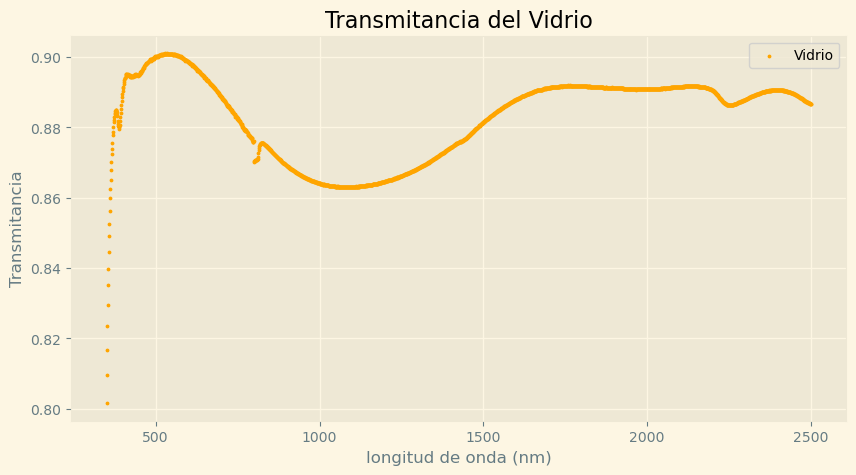

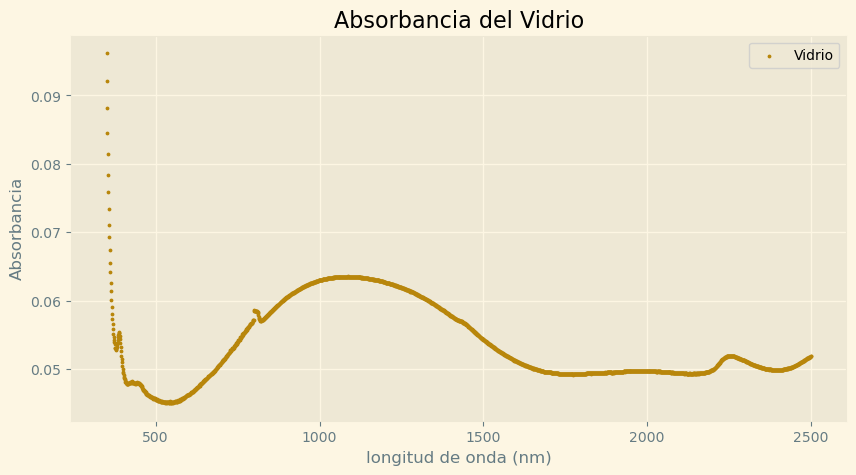

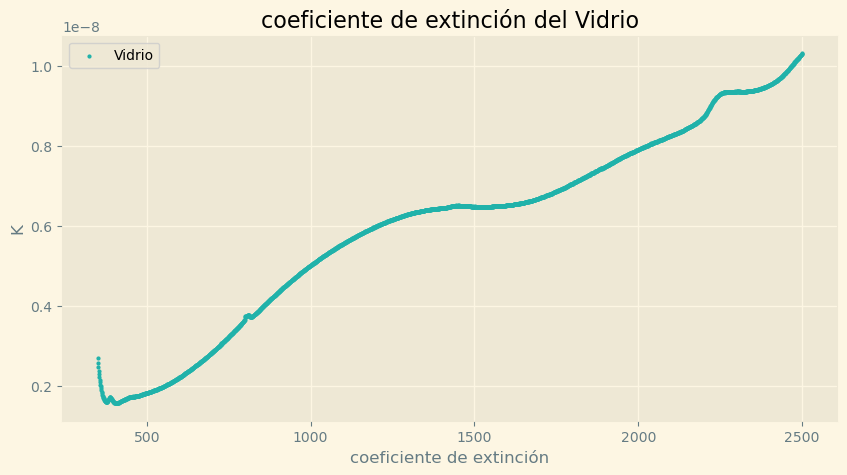

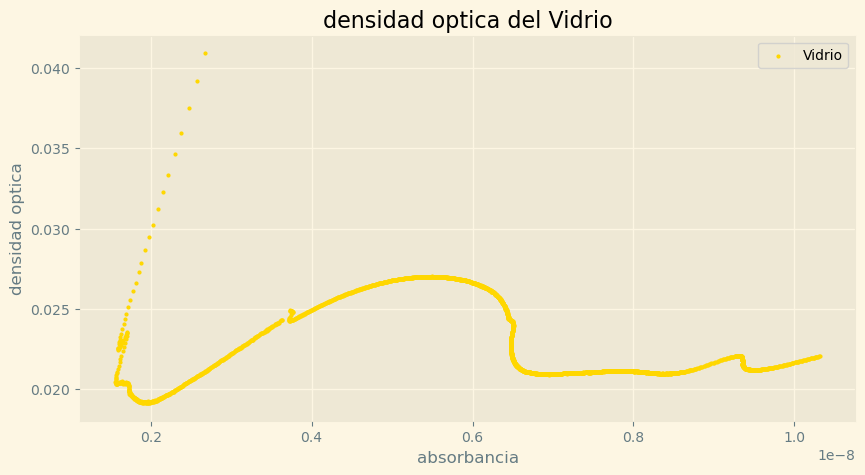

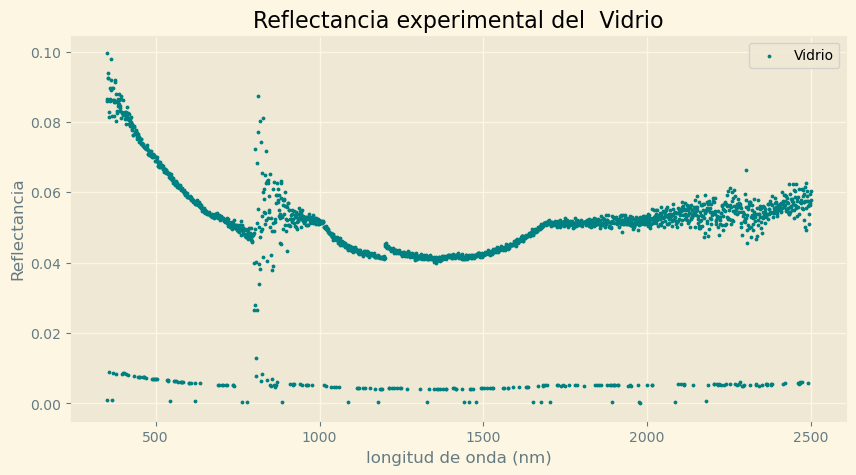

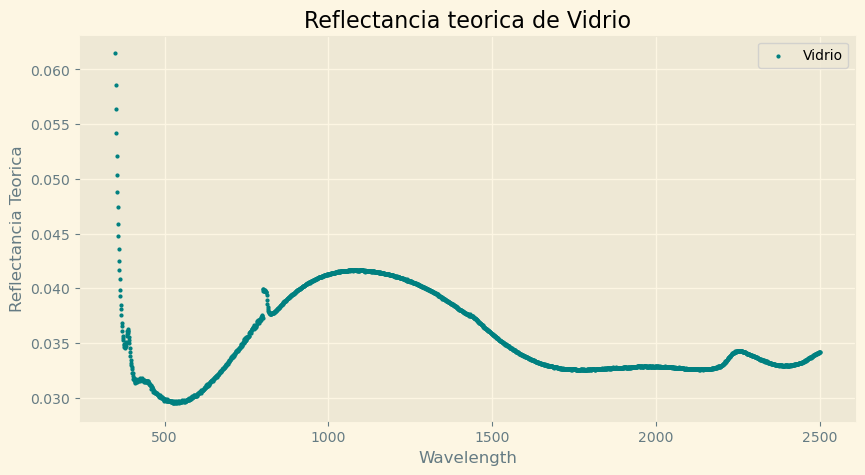

In [96]:
k_vidrio=vidrio.k_calc()
r_teorica_vidrio = vidrio.R_theoric_calc()
vidrio.graph_T()
vidrio.graph_abs()
vidrio.graph_k(k_vidrio)
vidrio.graph_do(k_vidrio,vidrio.do_calc())
vidrio.graph_R()
vidrio.graph_R_Theoric(r_teorica_vidrio)

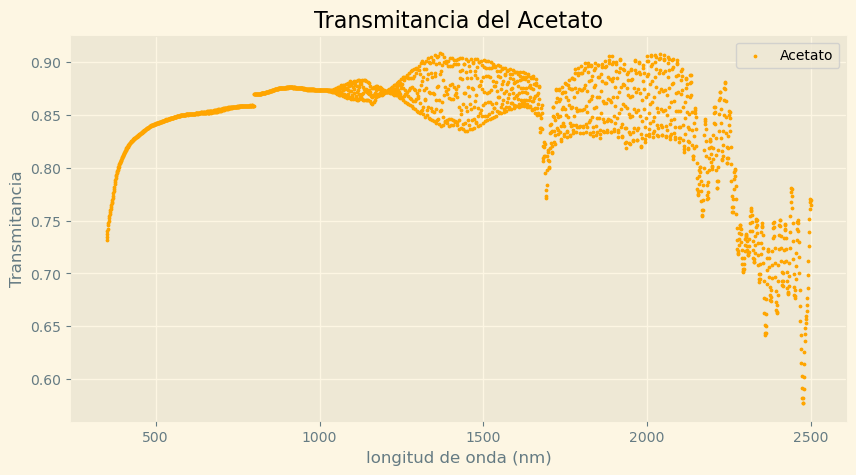

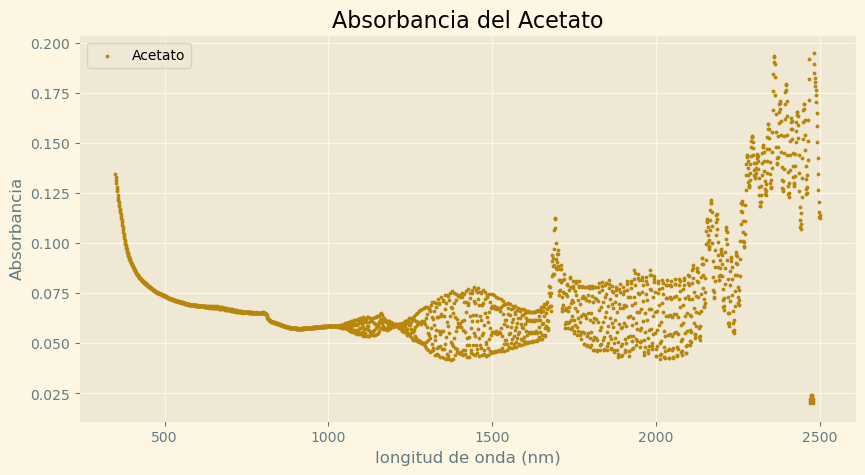

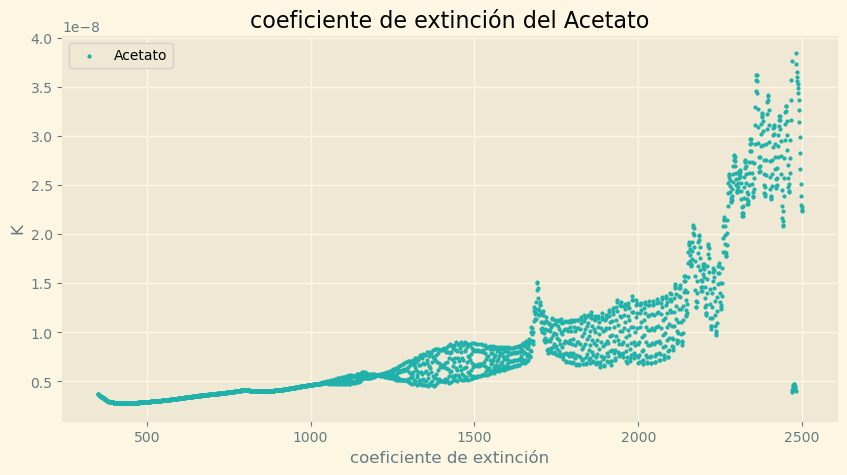

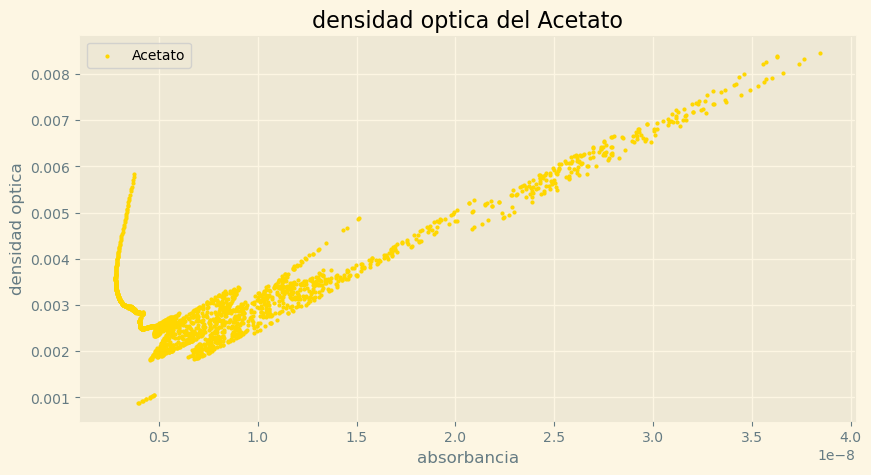

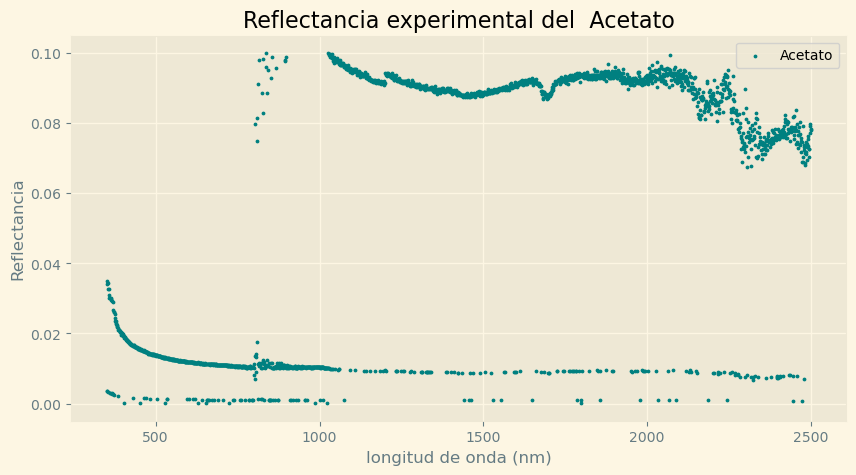

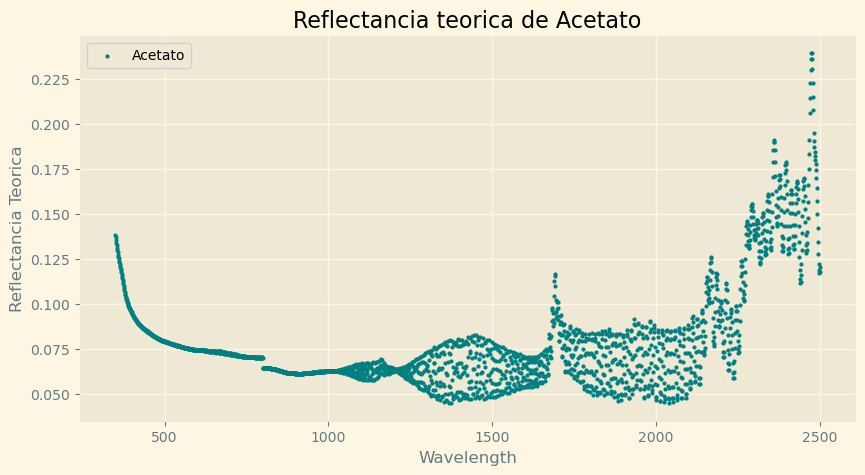

In [69]:
k_acetato=acetato.k_calc()
r_teorica_acetato = acetato.R_theoric_calc()
acetato.graph_T()
acetato.graph_abs()
acetato.graph_k(k_acetato)
acetato.graph_do(k_acetato,acetato.do_calc())
acetato.graph_R()
acetato.graph_R_Theoric(r_teorica_acetato)


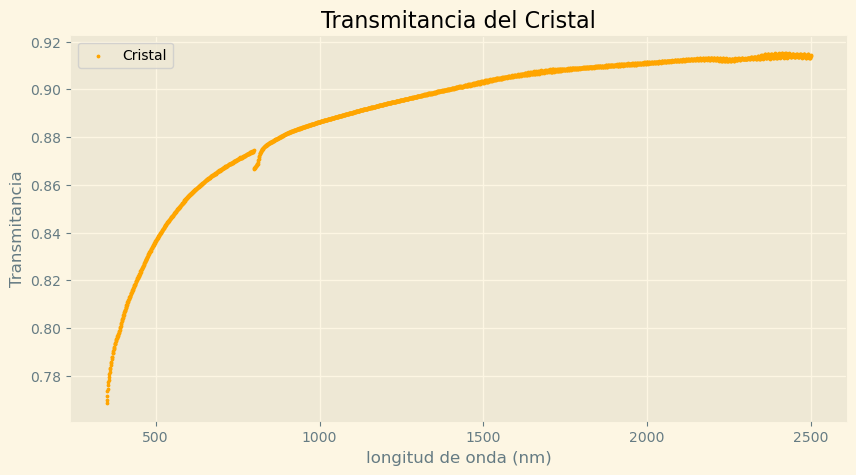

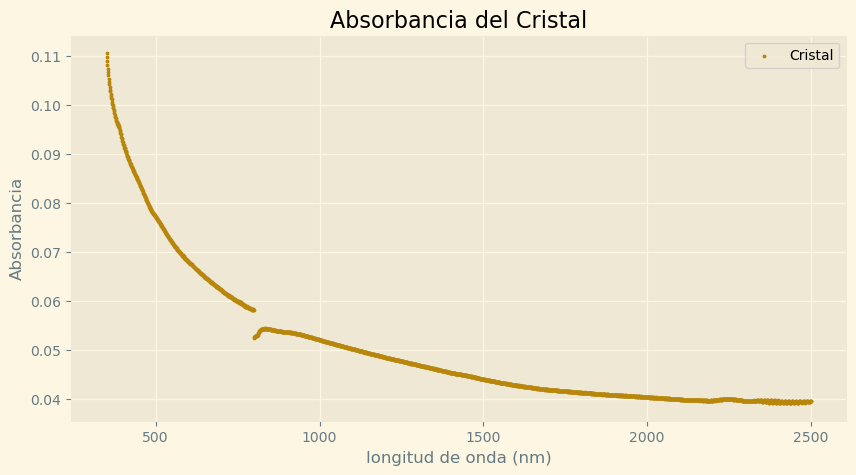

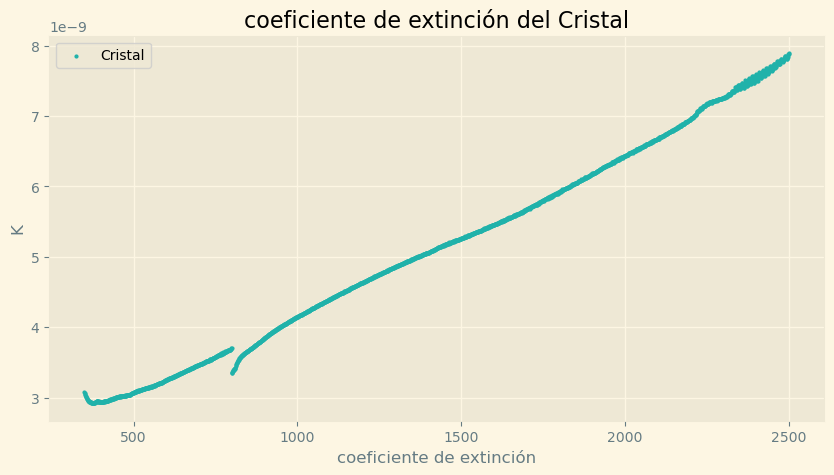

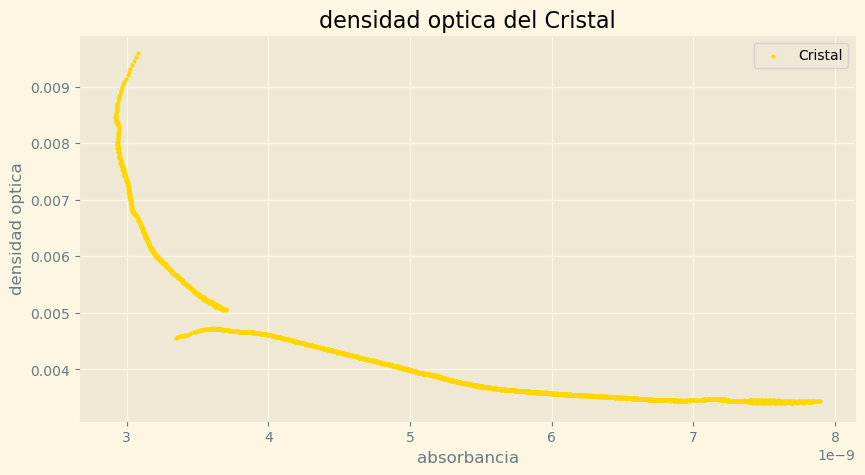

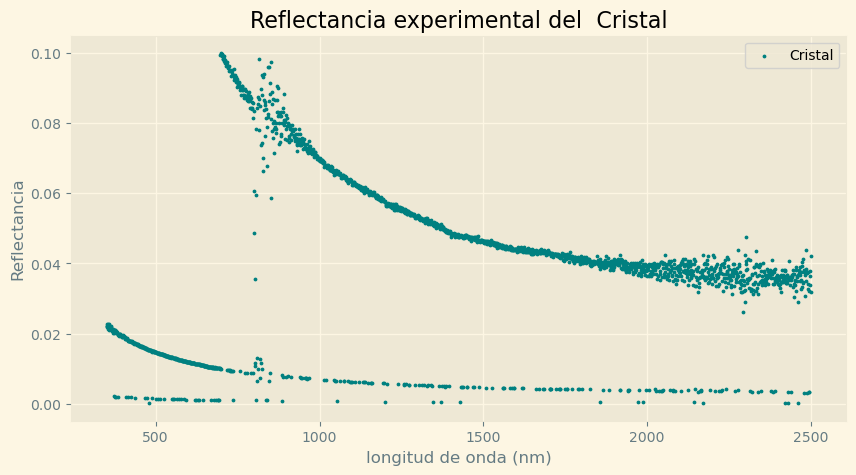

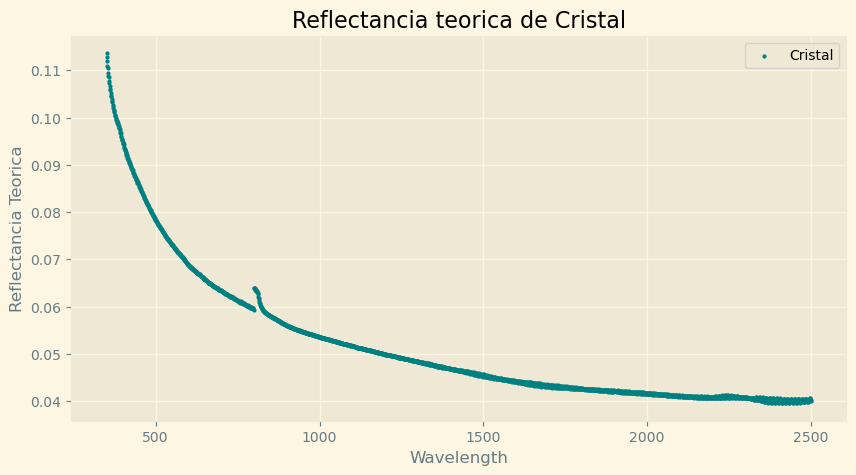

In [70]:
k_cristal=cristal.k_calc()
r_teorica_cristal = cristal.R_theoric_calc()
cristal.graph_T()
cristal.graph_abs()
cristal.graph_k(k_cristal)
cristal.graph_do(k_cristal,cristal.do_calc())
cristal.graph_R()
cristal.graph_R_Theoric(r_teorica_cristal)


# Gráficas Multiples

## Gráficas Reflectancia vs Reflectancia teórica

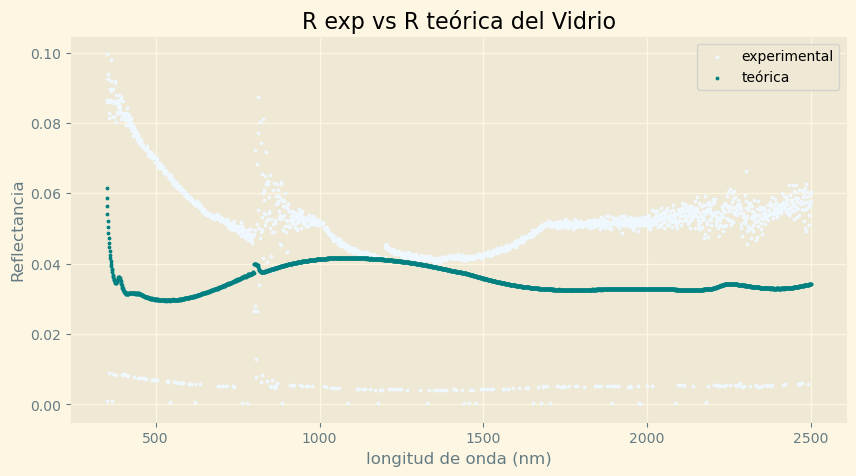

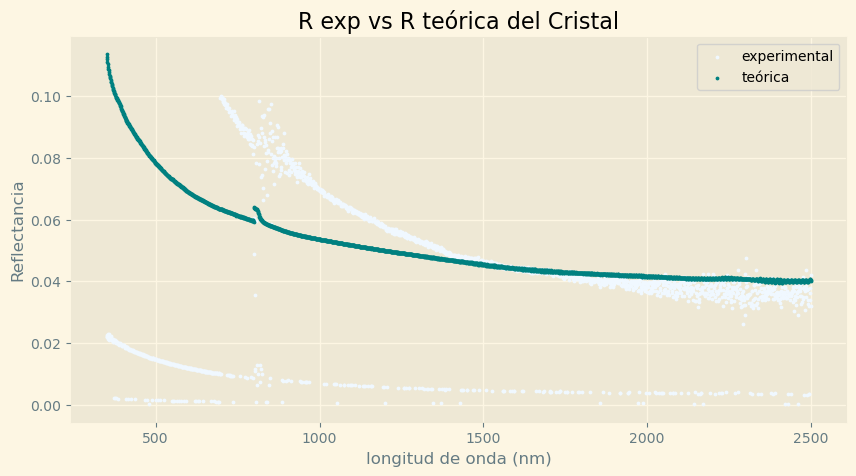

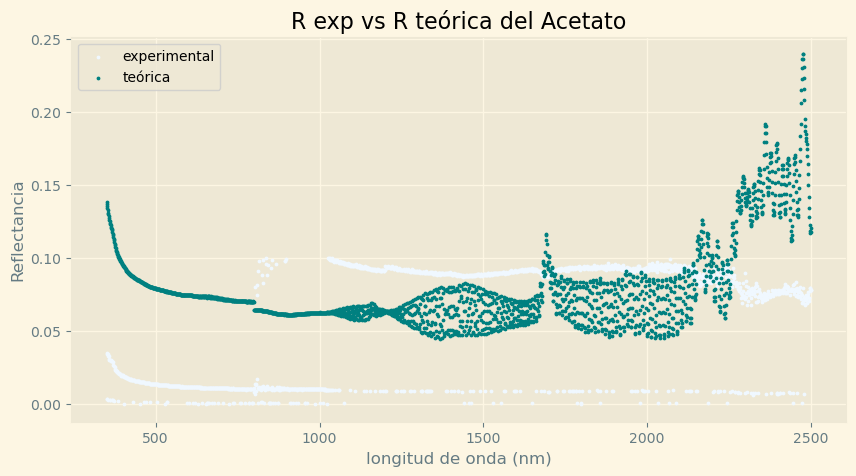

In [87]:
 vidrio.graphR_expVsTheoric(r_teorica_vidrio)
 cristal.graphR_expVsTheoric(r_teorica_cristal)
 acetato.graphR_expVsTheoric(r_teorica_acetato)
 

## Transmitancia experimental vs teórica

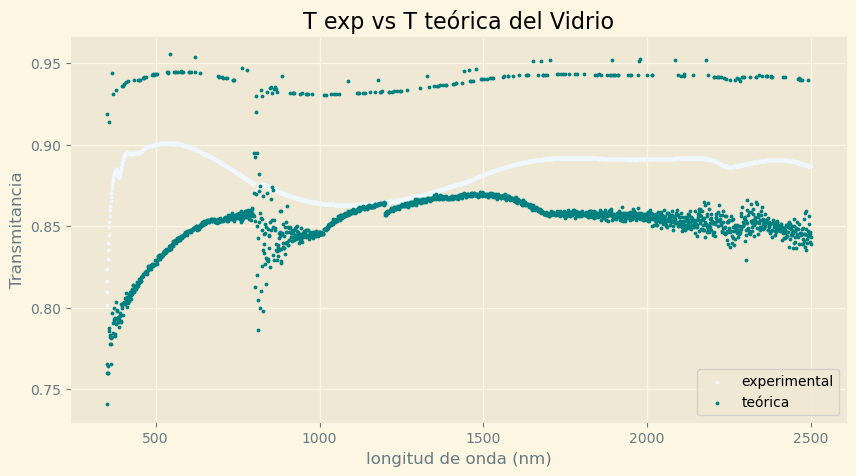

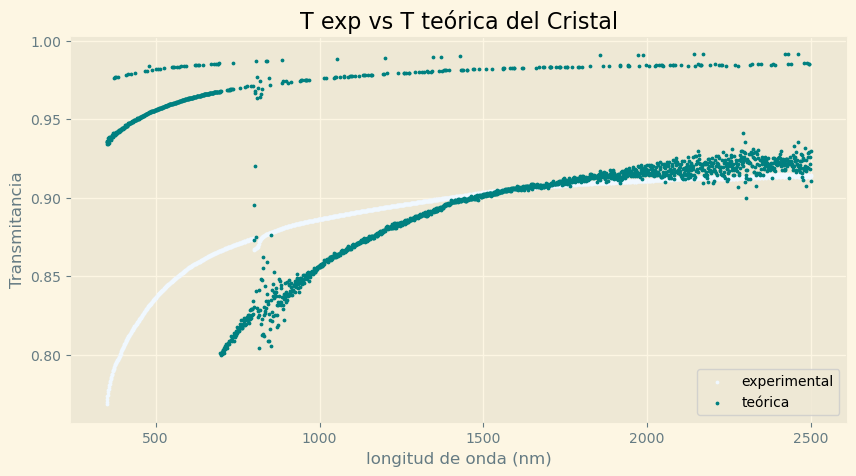

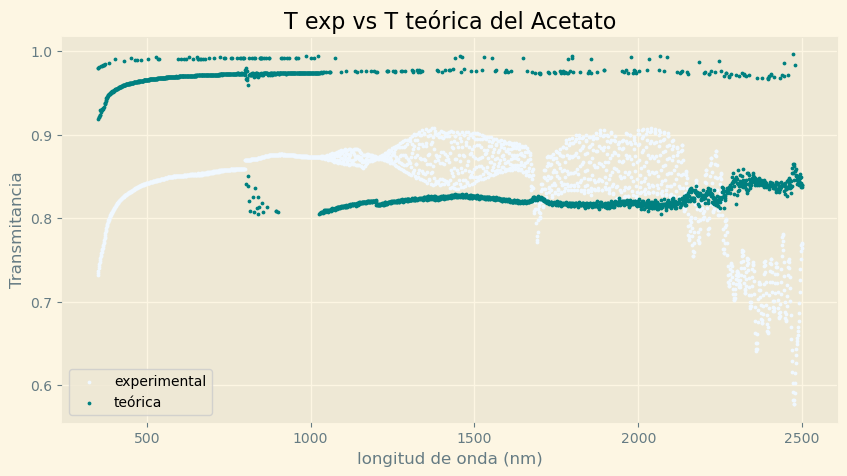

In [103]:
t_teorica_vidrio = vidrio.T_theoric_calc()
t_teorica_cristal = cristal.T_theoric_calc()
t_teorica_acetato = acetato.T_theoric_calc()
vidrio.graphT_expVsTheoric(t_teorica_vidrio)
cristal.graphT_expVsTheoric(t_teorica_cristal)
acetato.graphT_expVsTheoric(t_teorica_acetato)

## Comparación reflectancia teórica y Transmitancia

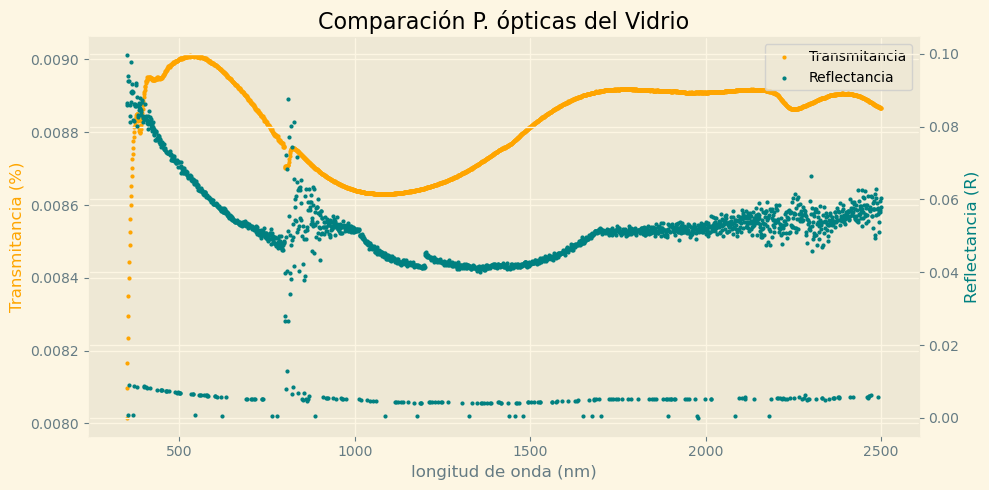

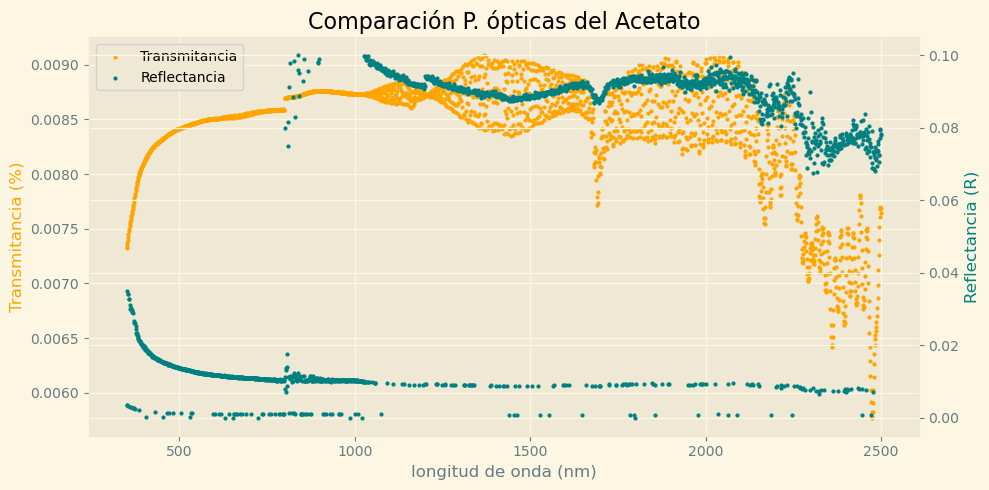

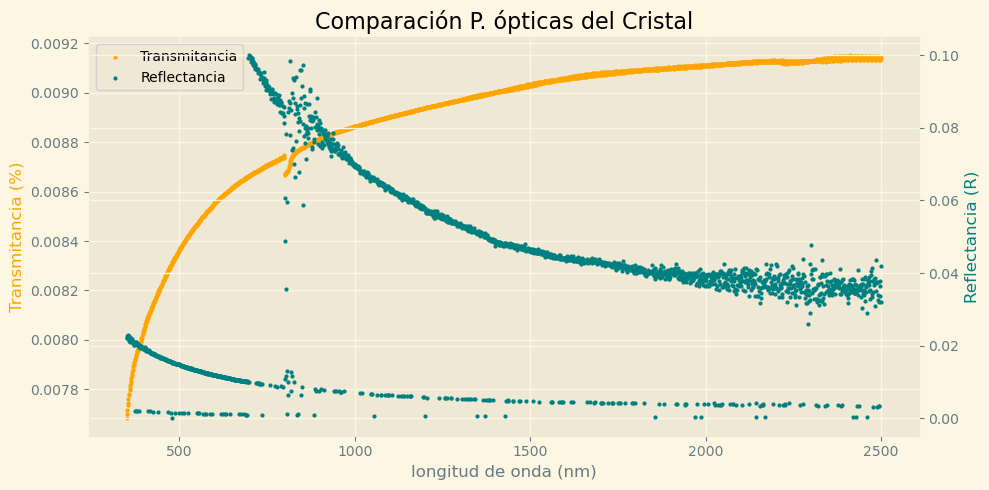

In [110]:
vidrio.multiple_graph_absT()
acetato.multiple_graph_absT()
cristal.multiple_graph_absT()

In [73]:
shouldBeOne = np.abs(np.power(np.e,0.5*vidrio.absorbancia*vidrio.l)*np.sqrt(vidrio.transmitancia)) + r_teorica_vidrio
print(np.min(shouldBeOne))
print(np.max(shouldBeOne))


1.0
1.0


<function matplotlib.pyplot.show(close=None, block=None)>

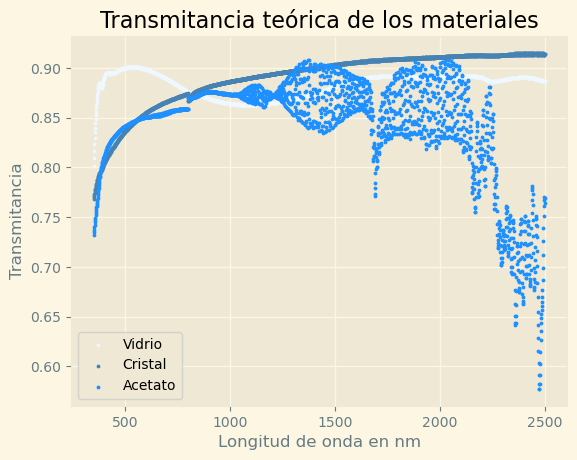

In [74]:
plt.scatter(vidrio.wavelength,vidrio.transmitancia,s=3,label=vidrio.name,color="aliceblue")
plt.scatter(vidrio.wavelength,cristal.transmitancia,s=3,label=cristal.name,color="steelblue")
plt.scatter(vidrio.wavelength,acetato.transmitancia,s=3,label=acetato.name,color="dodgerblue")
plt.xlabel("Longitud de onda en nm")
plt.ylabel("Transmitancia")
plt.title("Transmitancia teórica de los materiales")
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

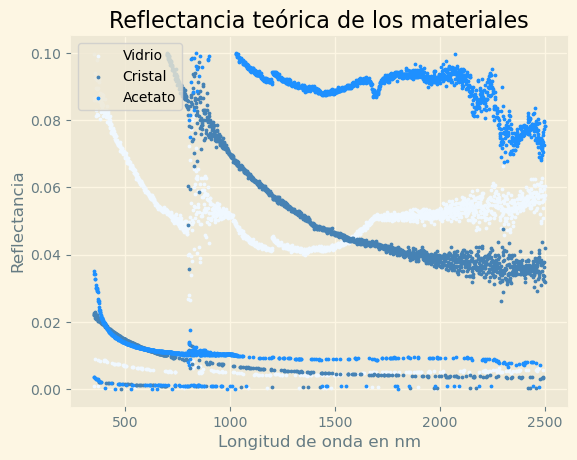

In [112]:
plt.scatter(vidrio.wavelength,vidrio.reflectancia,s=3,label=vidrio.name,color="aliceblue")
plt.scatter(vidrio.wavelength,cristal.reflectancia,s=3,label=cristal.name,color="steelblue")
plt.scatter(vidrio.wavelength,acetato.reflectancia,s=3,label=acetato.name,color="dodgerblue")
plt.xlabel("Longitud de onda en nm")
plt.ylabel("Reflectancia")
plt.title("Reflectancia teórica de los materiales")
plt.legend()
plt.show

## Indice de refracción n en la región de transparencia

Para el calculo del Indice de refracción podemos usar la región transparente por los altos valores de Transmitancia


In [61]:
def plot_n(n_usado,color_usado,nombre):
    plt.scatter(vidrio.wavelength,n_usado,s=2,color=color_usado)
    plt.xlabel("longitud de onda en nm")
    plt.ylabel("n")
    plt.title(f'Indice de refracción del {nombre}' )
            

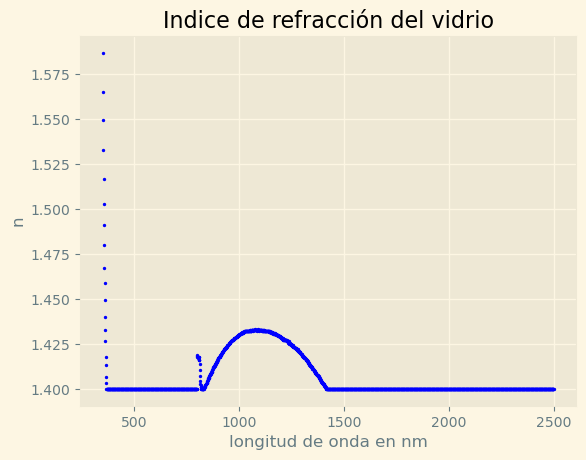

In [62]:
n_vidrio = vidrio.indice_de_refrac(vidrio.transmit,k_vidrio,1.4,1.9)
plot_n(n_vidrio,"blue","vidrio")

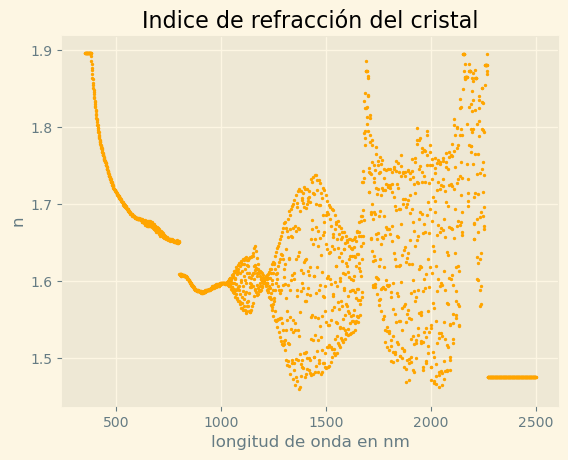

In [72]:
n_cristal = cristal.indice_de_refrac(r_teorica_cristal,k_cristal,0.9,1.9)
plot_n(n_acetato,"orange","cristal")

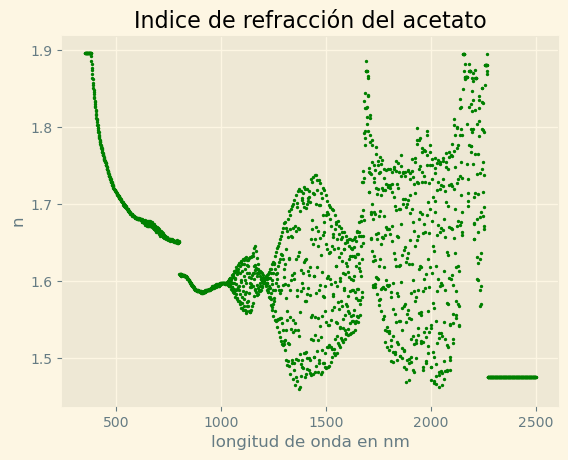

In [73]:
n_acetato = acetato.indice_de_refrac(r_teorica_acetato,k_acetato,0.9,1.9)
plot_n(n_acetato,"green","acetato") 

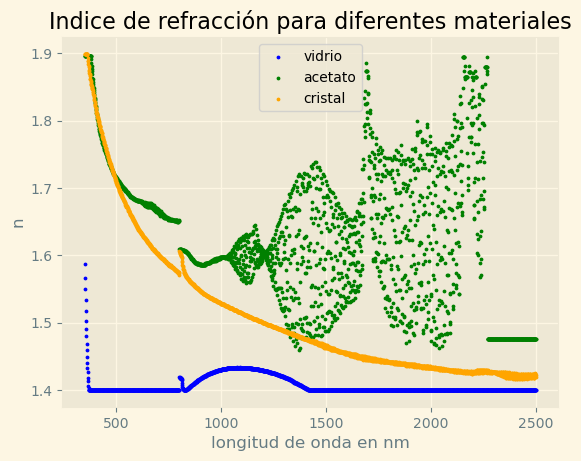

In [74]:
    plt.scatter(vidrio.wavelength,n_vidrio,label="vidrio",s=3,color="blue")
    plt.scatter(acetato.wavelength,n_acetato,label="acetato",s=3,color="green")
    plt.scatter(cristal.wavelength,n_cristal,label="cristal",s=3,color="orange")
    plt.xlabel("longitud de onda en nm")
    plt.ylabel("n")
    plt.title("Indice de refracción para diferentes materiales")
    plt.legend()

In [75]:
print(f'el indice de refracción del vidrio  encontrado es {np.round(np.mean(n_vidrio),3)} comparado al aceptado {vidrio.refraction_coefficient}')
print(f'el indice de refracción del cristal  encontrado es {np.round(np.mean(n_cristal),3)} comparado al aceptado {cristal.refraction_coefficient}')
print(f'el indice de refracción del acetato  encontrado es {np.round(np.mean(n_acetato),3)} comparado al aceptado {acetato.refraction_coefficient}')

el indice de refracción del vidrio  encontrado es 1.407 comparado al aceptado 1.5
el indice de refracción del cristal  encontrado es 1.512 comparado al aceptado 1.5
el indice de refracción del acetato  encontrado es 1.632 comparado al aceptado 1.475
